In [12]:

from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score






In [ ]:

def backbone(input_shape):
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return models.Model(inputs, x, name='backbone')


In [ ]:

def mask_head(features, num_classes, input_shape):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(features)
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(num_classes, (2, 2), strides=(2, 2), activation='softmax', padding='same')(x)
    return x

def box_head(features):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(features)
    x = layers.Flatten()(x)
    x = layers.Dense(4, activation='linear')(x) 
    return x

In [ ]:

def yolact_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    backbone_model = backbone(input_shape)
    features = backbone_model(inputs)

    mask_output = mask_head(features, num_classes, input_shape)
    box_output = box_head(features)

    return models.Model(inputs, [box_output, mask_output])




In [16]:
def load_data_coco(image_dir, annotation_file, input_size, num_classes):
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()

    images, masks = [], []
    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, input_size)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((input_size[0], input_size[1]), dtype=np.uint8)

        for ann in anns:
            mask = np.maximum(mask, cv2.resize(coco.annToMask(ann), input_size))

        images.append(img)
        masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks)
    masks = np.eye(num_classes)[masks]
    masks = masks.reshape(-1, input_size[0], input_size[1], num_classes)

    return images, masks

In [ ]:

train_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train"
train_annotation_file =r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train.coco.json"
val_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\val"
val_annotation_file =r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\val.coco.json"

input_shape = (128, 128, 3)
num_classes = 4

X_train, Y_train = load_data_coco(train_image_dir, train_annotation_file, (128, 128), num_classes)
X_val, Y_val = load_data_coco(val_image_dir, val_annotation_file, (128, 128), num_classes)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


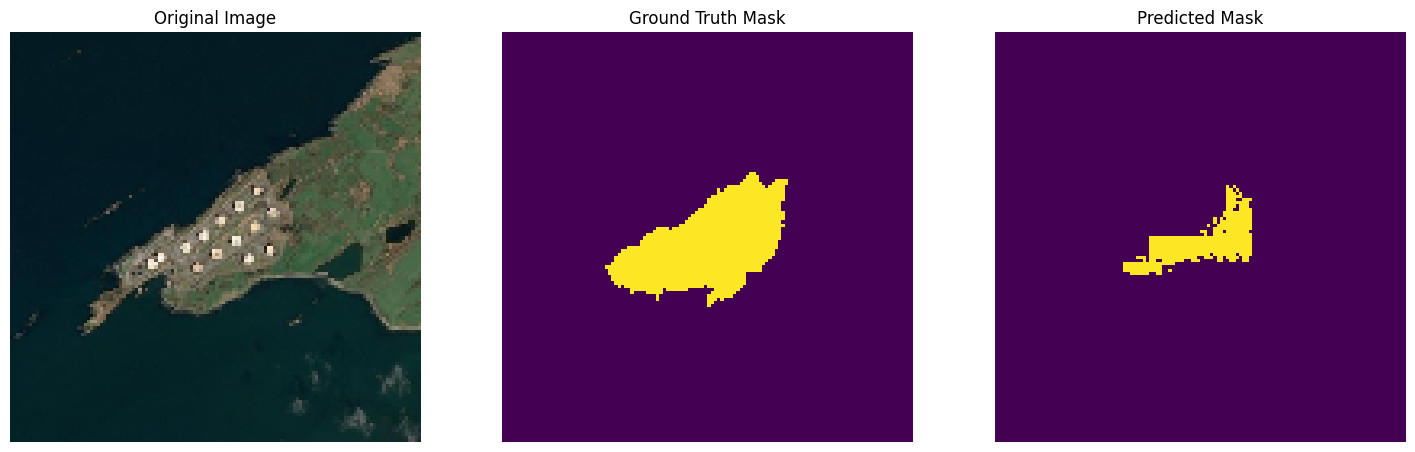

In [ ]:

sample_image = X_val[0]
true_mask = Y_val[0].argmax(axis=-1)
predicted_mask = model.predict(sample_image[np.newaxis, ...])[1][0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

true_masks_flat = true_masks_flat.astype(int)
pred_masks_flat = pred_masks_flat.astype(int)

precision = precision_score(true_masks_flat, pred_masks_flat, average='weighted')
recall = recall_score(true_masks_flat, pred_masks_flat, average='weighted')
f1 = f1_score(true_masks_flat, pred_masks_flat, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7994
Recall: 0.8334
F1 Score: 0.7859


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


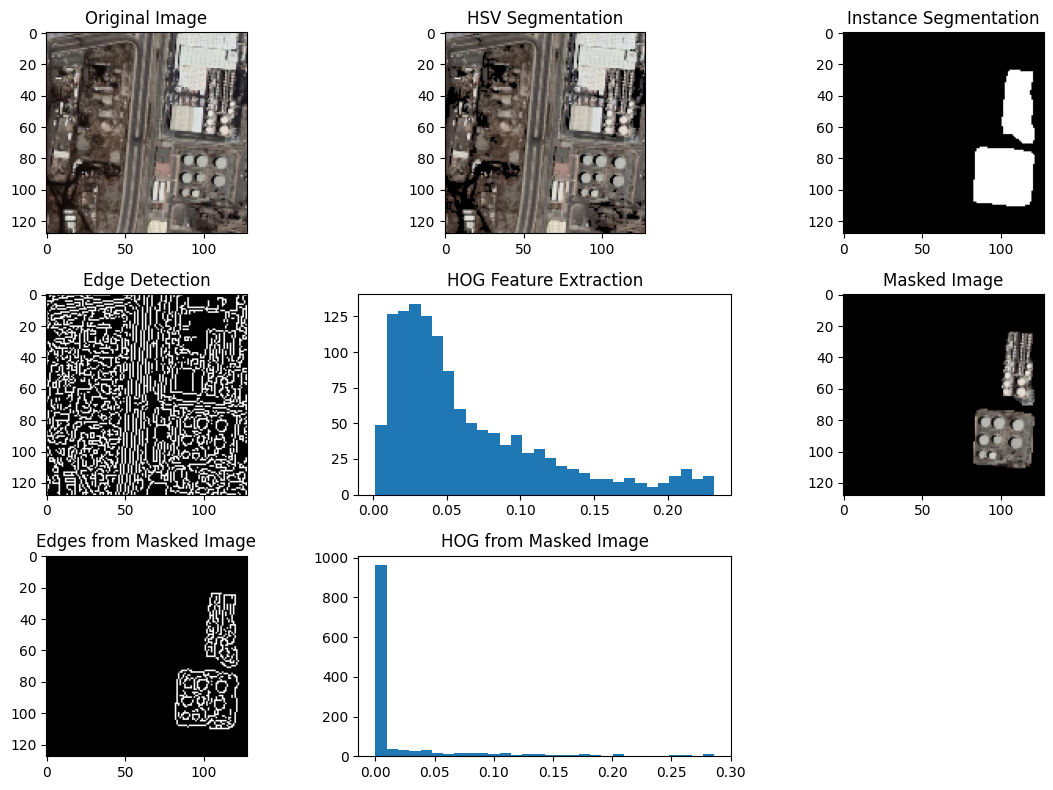

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

def load_data_coco(image_dir, annotation_file, input_size):
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()
    images, masks = [], []
    
    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error loading image: {img_path}")
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, input_size)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        for ann in anns:
            mask += coco.annToMask(ann)

        mask = cv2.resize(mask, input_size, interpolation=cv2.INTER_NEAREST)
        images.append(img_rgb)
        masks.append(mask)

    return np.array(images), np.array(masks)

def hsv_segmentation(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_bound = np.array([0, 0, 50])
    upper_bound = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    return cv2.bitwise_and(image, image, mask=mask)

def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

def hog_feature_extraction(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized_gray = cv2.resize(gray, (64, 64))  

    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(resized_gray)
    return h.flatten()

def extract_features_from_segmentation(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
    masked_edges = edge_detection(masked_image)
    masked_hog = hog_feature_extraction(masked_image)
    return masked_image, masked_edges, masked_hog


train_image_dir = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train"
train_annotation_file = r"C:\Users\sowmiyasagadevan\OneDrive\Desktop\project\dataset\seg(coco)\train.coco.json"

X_train, Y_train = load_data_coco(train_image_dir, train_annotation_file, (128, 128))

if len(X_train) == 0:
    raise ValueError("No images loaded. Please check dataset paths.")
sample_image = X_train[4]
sample_mask = (Y_train[4] > 0).astype(np.uint8)  

hsv_result = hsv_segmentation(sample_image)
edges = edge_detection(sample_image)
hog_features = hog_feature_extraction(sample_image)

seg_image, seg_edges, seg_hog = extract_features_from_segmentation(sample_image, sample_mask)

plt.figure(figsize=(12, 8))

plt.subplot(3, 3, 1), plt.imshow(sample_image), plt.title('Original Image')
plt.subplot(3, 3, 2), plt.imshow(hsv_result), plt.title('HSV Segmentation')
plt.subplot(3, 3, 3), plt.imshow(sample_mask, cmap='gray'), plt.title('Instance Segmentation')

plt.subplot(3, 3, 4), plt.imshow(edges, cmap='gray'), plt.title('Edge Detection')
plt.subplot(3, 3, 5), plt.hist(hog_features, bins=30), plt.title('HOG Feature Extraction')

plt.subplot(3, 3, 6), plt.imshow(seg_image), plt.title('Masked Image')
plt.subplot(3, 3, 7), plt.imshow(seg_edges, cmap='gray'), plt.title('Edges from Masked Image')
plt.subplot(3, 3, 8), plt.hist(seg_hog, bins=30), plt.title('HOG from Masked Image')

plt.tight_layout()
plt.show()
